## Name: Moad Saad Khorchef<br>
## ID: 200934655


## Basic Solution 


In [1]:
#from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile
import soundfile


#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
#drive.mount('/content/drive')

### Feature Extraction 

In [2]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate,hop_length=512,n_fft=2048).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=sample_rate, hop_length=512,n_fft=2048).T,axis=0) ###
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients



def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs, frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag



def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        # my added features
        #######
        y = waveform
        sr = sample_rate
        stft_=np.abs(librosa.stft(waveform))

        cent = np.mean( librosa.feature.spectral_centroid(y=y, sr=sr,hop_length=512,n_fft=2048).T, axis=0)
        contrast = np.mean( librosa.feature.spectral_contrast(S=stft_, sr=sr,hop_length=512,n_fft=2048).T, axis=0)
        #tonnetz = np.mean( librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sample_rate ,hop_length=512).T,axis=0)#
        rms = np.mean( librosa.feature.rms(y=y,frame_length=2048 ,hop_length=512).T, axis=0)
        spec_bw = np.mean( librosa.feature.spectral_bandwidth(y=y, sr=sr ,n_fft=2048, hop_length=512).T, axis=0)
        rolloff = np.mean( librosa.feature.spectral_rolloff(y=y, sr=sr ,n_fft=2048, hop_length=512).T, axis=0)
        zcr = np.mean( librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512).T, axis=0) 
        #######

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients , cent, contrast, rms, spec_bw, rolloff, zcr))
        
        return feature_matrix

In [3]:
#import os, glob

#def load_data():
#    X,y=[],[]
#    count = 0
#    for file in glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav'):
#        file_name=os.path.basename(file)
#        fileID = file.split('/')[-1]
#        features = get_features(file)
#        X.append(features)
       # y.append(emotion)
#        count += 1
        # '\r' + end='' results in printing over same line
#        print('\r' + f' Processed {count}/{20000} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
#    return np.array(X)

In [4]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    for file in tqdm(files):
        file = file.replace("\\", "/")
        fileID = file.split("/")[-1]
        #print(fileID)
        yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
        label = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
        if onlySingleDigit and yi>9:
            continue
        else:
            fs = None # if None, fs would be 22050
            x, fs = librosa.load(file,sr=fs)
            if scale_audio: x = x/np.max(np.abs(x))
            f0, voiced_flag = getPitch(x,fs,winLen=0.02)

            power = np.sum(x**2)/len(x)
            pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
            pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
            voiced_fr = np.mean(voiced_flag)

            #added 
            features = get_features(file)

            #xi = [power,pitch_mean,pitch_std,voiced_fr]

            xi = np.hstack((power,pitch_mean,pitch_std,voiced_fr,features))

            X.append(xi)
            y.append(label)
    return np.array(X),np.array(y)

In [10]:
labels = pd.read_csv('./Data/MLEnd/trainingMLEnd.csv')
labels


,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


In [11]:
files = glob.glob("./Data/MLEnd/training/Training/*.wav" )


X,y = getXy(files[:6000],labels_file=labels,scale_audio=True, onlySingleDigit=True)

#a,b = getXy(files[:1000],labels_file=labels,scale_audio=True, onlySingleDigit=True)



  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]C:\Users\Moad\anaconda3\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [14:54<00:00,  6.70it/s]


In [151]:
files = glob.glob('./Data/MLEnd/training/Training/*.wav')
len(files)

20000

In [12]:
#print('The shape of X is', a.shape) 
#print('The shape of y is', b.shape)
#print('The labels vector is', y)

In [13]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
#print('The labels vector is', y)

The shape of X is (1949, 196)
The shape of y is (1949,)


### Best Feature Selection

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif#

#X.shape
X_new = SelectKBest(mutual_info_classif, k=190).fit_transform(X, y)
#X_new = SelectKBest(mutual_info_classif, k=150).fit_transform(a, b)

X_new.shape


(1949, 190)

In [15]:
print(f'\nAudio samples represented: {X_new.shape[0]}')
print(f'Numerical features extracted per sample: {X_new.shape[1]}')
features_df = pd.DataFrame(X_new) # make it pretty for display
features_df


Audio samples represented: 1949
Numerical features extracted per sample: 190


,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,0.010129,208.882834,118.829623,0.215278,0.753131,0.766886,0.749057,0.671027,0.634170,0.670543,...,12.066502,13.726420,15.600197,15.085901,15.386061,19.041806,0.009657,2197.995732,4693.939209,0.159003
1,0.035339,157.289085,31.784415,0.293333,0.583537,0.643321,0.677088,0.669812,0.709702,0.740893,...,13.944263,15.772536,16.208509,17.446751,17.795718,27.592407,0.031027,2434.352641,5335.701069,0.155646
2,0.013676,134.964540,4.520547,0.084507,0.677341,0.748570,0.695867,0.597716,0.595714,0.726472,...,12.323731,16.377326,15.793714,20.858538,21.230001,19.016606,0.031680,1446.833328,1627.869907,0.027166
3,0.052517,181.944641,40.719889,0.494253,0.569682,0.537822,0.540425,0.537556,0.533592,0.509157,...,15.977014,20.075173,18.970150,17.982028,19.588298,25.813768,0.078083,1994.697128,3658.686967,0.105957
4,0.027461,109.742686,18.208426,0.120000,0.704168,0.769274,0.750523,0.715473,0.715584,0.750014,...,11.006136,14.597893,15.629837,15.968503,17.372982,28.002703,0.073354,1915.549197,4090.016602,0.118665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,0.012427,218.320824,74.117411,0.215190,0.671424,0.675539,0.718936,0.770489,0.783567,0.700486,...,13.106332,14.723138,14.927029,16.610873,16.490449,22.097368,0.038017,2287.243290,5410.558000,0.220672
1945,0.019418,244.020822,69.803627,0.337349,0.687252,0.701269,0.734410,0.739803,0.626294,0.625772,...,15.619662,16.779178,16.662217,16.648297,15.834053,25.801179,0.064158,2398.899065,4433.504918,0.065118
1946,0.055544,205.535959,44.520564,0.508065,0.500811,0.442746,0.422549,0.392942,0.397227,0.447477,...,18.152734,22.305314,22.854587,25.405481,27.847928,33.575963,0.165468,1813.729011,3224.423513,0.081496
1947,0.022832,270.207906,77.876257,0.302632,0.584216,0.621987,0.611628,0.667121,0.762832,0.667282,...,16.730680,18.322132,17.769921,18.166319,21.190978,22.895909,0.025193,2193.073818,5535.166530,0.206826


### Class Balance Check 

In [16]:
intonation_list = np.unique(y)
intonation_list

array(['bored', 'excited', 'neutral', 'question'], dtype='<U8')

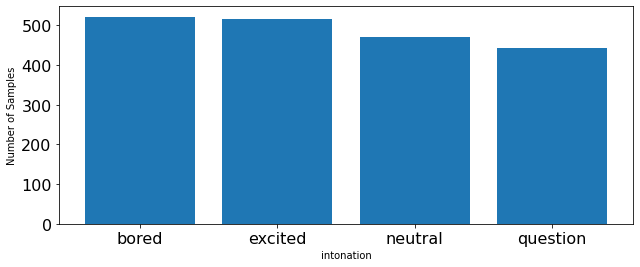

In [17]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
intonation_list, count = np.unique(y, return_counts=True)
plt.bar(x=range(4), height=count)
plt.xticks(ticks=range(4), labels = [intonation for intonation in intonation_list],fontsize=10)
plt.xlabel('intonation')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [18]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
    idx = np.isnan(X).sum(1)>0
    X = X[~idx]
    y = y[~idx]
print(np.sum(np.isnan(X)))

0


### Normalising

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_scaled = X
#features_scaled = a
features_scaled = X_new
features_scaled = scaler.fit_transform(features_scaled)

#scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_minmax = features
#features_minmax = scaler.fit_transform(features_minmax)

In [20]:
features_scaled_df = pd.DataFrame(features_scaled) # make it pretty for display
features_scaled_df

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,-0.842976,0.400776,3.385139,-0.579043,0.799140,1.027576,0.857193,0.111030,-0.139985,0.260398,...,-1.232015,-1.458734,-0.386383,-1.335666,-1.373209,-1.175288,-0.711562,-0.066101,-0.012779,0.290658
1,0.876839,-0.247284,0.142631,-0.091997,-0.860901,-0.174619,0.164147,0.099436,0.549521,0.899578,...,-0.398668,-0.524623,-0.095913,-0.112957,-0.236553,0.978520,0.038124,0.557227,0.458210,0.248346
2,-0.600979,-0.527699,-0.872971,-1.395019,0.057287,0.849369,0.344986,-0.588274,-0.491041,0.768550,...,-1.117857,-0.248518,-0.293978,1.654044,1.383427,-1.181635,0.061036,-2.047093,-2.262965,-1.370896
3,2.048664,0.062410,0.475485,1.161689,-0.996521,-1.201049,-1.151872,-1.162142,-1.058135,-1.205914,...,0.503463,1.439656,1.222777,0.164269,0.609022,0.530499,1.688916,-0.602248,-0.772550,-0.377887
4,0.339394,-0.844506,-0.363086,-1.173552,0.319872,1.050802,0.871304,0.534995,0.603220,0.982447,...,-1.702604,-1.060881,-0.372230,-0.878557,-0.435961,1.081869,1.522988,-0.810979,-0.455997,-0.217723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,-0.686187,0.519325,1.719571,-0.579592,-0.000634,0.138839,0.567138,1.059792,1.223815,0.532453,...,-0.770540,-1.003703,-0.707822,-0.545867,-0.852259,-0.405623,0.283348,0.169265,0.513147,1.067873
1945,-0.209269,0.842139,1.558879,0.182652,0.154298,0.389172,0.716143,0.767077,-0.211884,-0.146379,...,0.344871,-0.065061,0.120734,-0.526485,-1.161887,0.527328,1.200383,0.463728,-0.203912,-0.892584
1946,2.255192,0.358737,0.617064,1.247870,-1.670651,-2.126057,-2.286985,-2.541593,-2.302972,-1.766326,...,1.469044,2.457780,3.077604,4.008954,4.505159,2.485716,4.754478,-1.079503,-1.091256,-0.686173
1947,0.023606,1.171070,1.859592,-0.033978,-0.854261,-0.382188,-0.466211,0.073773,1.034530,0.230769,...,0.837939,0.639342,0.649665,0.259715,1.365020,-0.204479,-0.166559,-0.079082,0.604597,0.893364


### Dataset Spliting

In [22]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
#X_train, X_val, y_train, y_val = train_test_split(
#    X, 
#    y, 
#    test_size=0.2, 
#    stratify=y
#)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    y, 
    test_size=0.2, 
    stratify=y
)


## Comparing Models

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    y, 
    test_size=0.2, 
    stratify=y
)

classification_models = [
    KNeighborsClassifier(),#(3),
    #SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_val_scaled, y_val)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
    
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

C:\Users\Moad\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Classifier,Accuracy Score
3,RandomForestClassifier,62.31%
0,KNeighborsClassifier,60.26%
1,SVC RBF kernel,58.21%
4,AdaBoostClassifier,50.00%
2,DecisionTreeClassifier,48.72%
6,QuadraticDiscriminantAnalysis,43.59%
5,GaussianNB,35.64%


### GridSearchCV SVM

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC


param_grid = { 'C':[1,2,3,4,5,6,7,8],'kernel':['rbf'],'gamma': [ 1, 0.1, 0.01 ]}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv= 5)
grid.fit(X_train_scaled,y_train)

# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(grid.score(X_val_scaled, y_val)))

#grid_predictions = grid.predict(X_val)
#print(confusion_matrix(y_val,grid_predictions))
#print(classification_report(y_val,grid_predictions))#Output

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ...................... C=4, gamma=0.01, kernel=rbf, total=   0.7s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ......................... C=5, gamma=1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ......................... C=5, gamma=1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ......................... C=5, gamma=1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ......................... C=5, gamma=1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ......................... C=5, gamma=1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=5, gamma=0.1, kernel=rbf, total=   0.8s
[CV] C=5, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ...................... C=8, gamma=0.01, kernel=rbf, total=   0.7s
[CV] C=8, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=8, gamma=0.01, kernel=rbf, total=   0.7s
[CV] C=8, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=8, gamma=0.01, kernel=rbf, total=   0.7s


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.5min finished


{'C': 8, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=8, gamma=0.01)
Test dataset accuracy of best hyperparameter setting: 0.6897435897435897.


### GridSearchCV RandomForestClassifier

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200,250,280,300,350],
    'max_features': ['sqrt']
}

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
grid.fit(X_train_scaled, y_train)


print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)
print('Test dataset accuracy (random forest classifier): {0}.'.format(grid.score(X_val_scaled, y_val)))

0.5791738807815979
{'max_features': 'sqrt', 'n_estimators': 200}
RandomForestClassifier(max_features='sqrt', n_estimators=200, n_jobs=-1,
                       oob_score=True)
Test dataset accuracy (random forest classifier): 0.6384615384615384.


## Advanced Solution


### RNN implementaion


tried to classify numeral unsuccessfully using pytorch RNN

In [47]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import time
import torch.optim as optim


In [125]:
#custom dataloader
from torch.utils.data.dataset import Dataset


class CustomDataset(Dataset):
    def __init__(self, data,label ):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.datas = torch.tensor(data,dtype=torch.float)
        self.labels = torch.tensor(label,dtype=torch.long) 
        self.length = len(self.labels)

    def __getitem__(self, index):
        
        a = self.datas[index]
        b = self.labels[index]

        return (a, b)

    def __len__(self):
        return self.length
        




In [126]:
X = np.load('X.npy')
y = np.load('y.npy')

In [127]:
X1 = X.reshape(6533,40,1 )
X1.shape

(6533, 40, 1)

In [128]:
customData = CustomDataset( X1,y)

In [129]:
train_loader = torch.utils.data.DataLoader(dataset = customData, batch_size=1, shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset = customData, batch_size=1, shuffle=True)


In [131]:
for data,label in train_loader:
    #print(data)
    #print(data.shape)
    print('lol')
    #print(label)
    #print(label.shape)
    break

lol


In [121]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(RNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
#         print(input_size)

        # embedding and LSTM layers
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        #print(x.shape)
        batch_size = x.size(0)
        
        print(batch_size)
        print(x.size())
        #print()

#         x = x.view()
        # embeddings and lstm_out
#         embeds = self.embedding(x)

#         x = x.view(4, batch_size, 48)
        
        lstm_out, hidden = self.lstm(x, hidden)
#         print(lstm_out.shape)

        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.logsoftmax(out)

        # reshape to be batch_size first
#         sig_out = sig_out.view(batch_size, -1)
#         sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

In [130]:
input_size = 40
output_size = 1
hidden_dim = 1
n_layers = 1
model = RNN(input_size, output_size, hidden_dim, n_layers)

C:\Users\Moad\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [123]:
train_on_gpu=torch.cuda.is_available()
lr = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [124]:
epochs = 1
counter = 0
print_every = 100
clip = 5
batch_size = 1

if train_on_gpu:
    model.cuda()
model.train()

for e in range(epochs):
    h = model.init_hidden(batch_size)
    
    for data, label in train_loader:
             
        inputs = data
        labels = label 
        inputs = inputs#.unsqueeze(0)

        
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        
        print("yesd")
        
        output, h = model(inputs, h)
        
        print("yes2")
        
        print(input)
        print(label)
        print(output)
#         output = (output.unsqueeze(0))
#         labels = (labels.unsqueeze(0))
        
        loss = criterion(output, labels)
    
        #print(loss)
    
        loss.backward()
        
        
        print("yes3")
        
        
        
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter % print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
    
            for data, label in train_loader:
             
                inputs = data
                labels = label 
                
                val_h = tuple([each.data for each in val_h])
                
                inputs = inputs#.unsqueeze(0)

                
                if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                    
                output, val_h = model(inputs, val_h)
                
                
                #print(output)
                val_loss = criterion(output, labels)
                
                val_losses.append(val_loss.item())
            
            model.train()
            #print("Epoch: {}/{}...".format(e+1, epochs),
            #      "Step: {}...".format(counter),
            #      "Loss: {:.6f}...".format(loss.item()),
            #     "Val Loss: {:.6f}".format(np.mean(val_losses)))


yesd
1
torch.Size([1, 40, 1])
yes2
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025D2A296880>>
tensor([4])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


ValueError: Expected input batch_size (40) to match target batch_size (1).

In [ ]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
         
    hidden = None
    for data, label in train_loader:
             
        inputs = data
        labels = label       
        
#         # defining the training data 
#         time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
#         data = np.sin(time_steps)
#         data.resize((seq_length + 1, 1)) # input_size=1

#         x = data[:-1]
#         y = data[1:]
        
        # convert data into Tensors
#         x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
#         y_tensor = torch.Tensor(y)

        inputs = inputs#.unsqueeze(0)
        
        print(inputs.shape)
        
        if True:
            inputs, labels = inputs.cuda(), labels.cuda()
#         print(inputs)
#         print(inputs.shape)
#         print(labels.shape)

            
        
        # outputs from the rnn
        prediction, hidden = rnn(inputs, hidden)

        
#         print("yes")
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

#         print(prediction)
#         print(labels.unsqueeze(0))
        # calculate the loss
        
        print('prediction: ',prediction)
        print('labels: ', label)
        
        loss = criterion(prediction, labels)
        
                
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
               
#         rnn.to("cpu")
        
        optimizer.step()
       
               
        # display loss and predictions
                
        print('Loss: ', loss.item())
#         plt.plot(time_steps[1:], x, 'r.') # input
#         plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
#         plt.show()



    
    return rnn


In [ ]:
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

In [ ]:
#test the model
correct = 0
total = 0
hidden = None  
print(len(test_loader))
with torch.no_grad():
    
    for X, y in test_loader:
       
        X = X.cuda()
        y = y.cuda()
        
    
    output,hidden = trained_rnn(X, hidden)

    for idx, i in enumerate(output):
        if torch.argmax(i) == y[idx]:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))
